In [27]:
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
import cv2
import numpy as np
import cupy as cp
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '..')
from PIL import Image
from importlib import reload

In [20]:
img2D = np.asarray(cv2.imread('../image.jpg'))
model = YOLO('yolov8x-seg.pt')
decreaseByProbability = True

In [33]:
import imageToCostmap; reload(imageToCostmap);
from imageToCostmap import detectObjects #For faster iteration
costmapResult = detectObjects(img2D, model, decreaseByProbability)

0: 640x480 1 remote, 2 cell phones, 1 book, 26.0ms
Speed: 3.0ms preprocess, 26.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to c:\Users\c1a55\Documents\Roborouter\runs\segment\predict4


In [40]:
image = Image.fromarray(costmapResult * 255).convert("L")
image.save("../runs/costmaps/costmap.png")
print(costmapResult.shape)

(4000, 3000)


In [36]:
def depthToWorld(focalLength, cameraXYZ, cameraEuler, depthImage, colorImage):
    # Load the grayscale depth image
    depthImage = cv2.imread(depthImage, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    colorImage = cv2.imread(colorImage)
    
    # Image dimensions
    [imgHeight, imgWidth] = depthImage.shape[0:2]
    # Initialize matrix to hold world coordinates
    worldCoordinates = np.zeros((imgHeight, imgWidth, 6))
    
    # Convert Euler angles to rotation matrix
    rx = cameraEuler[0]
    ry = cameraEuler[1]
    rz = cameraEuler[2]
    
    Rx = np.matrix([[1, 0, 0], [0, np.cos(rx), -np.sin(rx)], [0, np.sin(rx), np.cos(rx)]])
    Ry = np.matrix([[np.cos(ry), 0, np.sin(ry)], [0, 1, 0], [-np.sin(ry), 0, np.cos(ry)]])
    Rz = np.matrix([[np.cos(rz), -np.sin(rz), 0], [np.sin(rz), np.cos(rz), 0], [0, 0, 1]])
    
    # The final rotation matrix is Rz * Ry * Rx
    rotationMatrix = Rx
    rotationMatrix = rotationMatrix * Ry
    rotationMatrix = rotationMatrix * Rz
    invRt = np.linalg.inv(rotationMatrix)
    
    # Calculate intrinsic matrix based on focal length and image dimensions
    cx = (imgWidth - 1) / 2  # Assuming the principal point is at the center
    cy = (imgHeight - 1) / 2 # Assuming the principal point is at the center
    intrinsicMatrix = np.matrix([[focalLength, 0, cx],
                       [0, focalLength, cy],
                       [0, 0, 1]])
    
    # Invert the intrinsic matrix for later use
    invIntrinsicMatrix = np.linalg.inv(intrinsicMatrix)
    
    # Loop over each pixel in the depth image
    for y in range(imgHeight):
        for x in range(imgWidth):
            
            depth = -1 * depthImage[y, x, 0]
            pixelCoords = np.matrix([[depth * x], [depth * y], [depth]])
            pixelCoords = invIntrinsicMatrix * pixelCoords
            pixelCoords = invRt * pixelCoords
            
            # Transform to world space
            #worldCoords = tfMatrix * pixelCoords + cameraXYZ
            
            # Store world coordinates
            worldCoordinates[y, x, 0:3] = pixelCoords.transpose() + cameraXYZ
            worldCoordinates[y, x, 3:6] = colorImage[y,x,:]
            points = worldCoordinates.reshape(-1, 6)

    return points

In [37]:
focalLength = 50.0*1920/36.0
cameraXYZ = -1 * np.matrix([5, 5, -2.5])
cameraXYZ[0, 1] = -1 * cameraXYZ[0, 1]
cameraEuler = [np.pi/4, 1.22173, 0] # Camera orientation as Euler angles (in radians)

depthImage = "../Depth.exr"
colorImage = "../Color.png"

# Call the function with an example depth image file
points = depthToWorld(focalLength, cameraXYZ, cameraEuler, depthImage, colorImage)

In [44]:
focalLength = 50.0*1920/36.0
cameraXYZ = -1 * np.matrix([-4, 6, 4])
cameraXYZ[0, 1] = -1 * cameraXYZ[0, 1]
cameraEuler = [np.pi/4, -2.44346, 0] # Camera orientation as Euler angles (in radians)

depthImage = "../DepthRear.exr"
colorImage = "../Color2.png"

# Call the function with an example depth image file
points2 = depthToWorld(focalLength, cameraXYZ, cameraEuler, depthImage, colorImage)

In [45]:
def plot(points):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(points[:,0], points[:,2], points[:,1], c = (np.matrix([points[:, 5], points[:, 4], points[:, 3]]).transpose() / 255))
    ax.set_aspect('equal')
    ax.set_xlabel("X")
    ax.set_ylabel("Z")
    ax.set_zlabel("Y")
    plt.title("3D Point Cloud from Depth Image")
    plt.show()

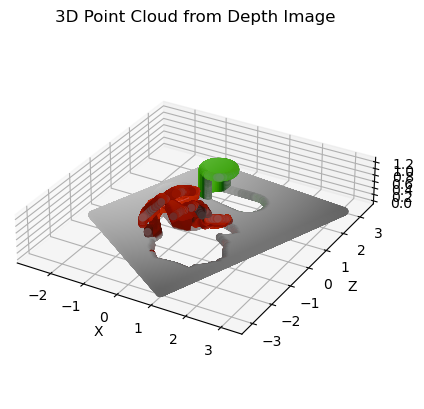

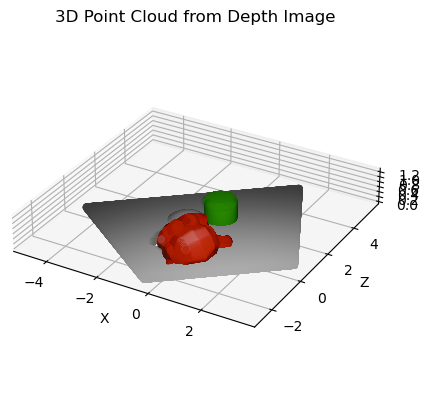

In [46]:
plot(points)
plot(points2)

In [47]:
def flatten(xSize, ySize, scale, points, minimumWeight = None, mapPoints = None):
    xOffset = xSize / 2
    yOffset = ySize / 2
    if mapPoints is None:
        mapPoints = np.zeros((xSize, ySize, 4))
    for point in points:
        xIndex = int((point[0]) * scale + xOffset)
        yIndex = ySize - 1 - int((point[2]) * scale + yOffset)

        if xIndex >= xSize or xIndex < 0 or yIndex >= ySize or yIndex < 0:
            continue
    
        if mapPoints[yIndex][xIndex][3] == 0:
            mapPoints[yIndex][xIndex] = [point[3], point[4], point[5], point[1]]
        else:
            if minimumWeight is not None:
                newWeight = max(point[1], minimumWeight)
                oldWeightTotal = mapPoints[yIndex][xIndex][3]
                newWeightTotal = oldWeightTotal + newWeight
                mapPoints[yIndex][xIndex][3] = newWeightTotal
                mapPoints[yIndex][xIndex][0:3] = (mapPoints[yIndex][xIndex][0:3] * oldWeightTotal + point[3:6] * newWeight) / newWeightTotal
            else:
                n = mapPoints[yIndex][xIndex][3] + 1
                mapPoints[yIndex][xIndex][3] = n
                mapPoints[yIndex][xIndex][0:3] = (mapPoints[yIndex][xIndex][0:3] * (n - 1) + point[3:6]) / n
    return mapPoints

In [51]:
xSize = 600
ySize = 600
scale = 80
minimumWeight = 0

mapPoints = flatten(xSize, ySize, scale, points, minimumWeight)
mapPoints = flatten(xSize, ySize, scale, points2, minimumWeight, mapPoints)
cv2.imwrite('../runs/costmaps/testMap.jpg', mapPoints[:, :, 0:3])

True

In [50]:
costmapResult = detectObjects(mapPoints[:, :, 0:3], model, decreaseByProbability)
image = Image.fromarray(costmapResult * 255).convert("L")
image.save("../runs/costmaps/mapCostmap.png")


0: 640x640 3 persons, 1 backpack, 1 handbag, 1 frisbee, 1 snowboard, 1 sports ball, 1 kite, 5 dining tables, 1 book, 358.0ms
Speed: 31.0ms preprocess, 358.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to c:\Users\c1a55\Documents\Roborouter\runs\segment\predict4
